# Projekat - Prevodilac
### Imports

In [13]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections
from skimage.filters import threshold_local
from googletrans import Translator
import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'/home/student/anaconda3/lib/python3.6/site-packages/pytesseract/pytesseract.py'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 20,16

# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

#scikit
from sklearn.cluster import KMeans


### Image processing methods

In [106]:

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
        
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False, aspect='equal'):
    plt.figure()
    if color:
        plt.imshow(image, aspect=aspect)
    else:
        plt.imshow(image, 'gray', aspect=aspect)

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def preprocess(img, blur="none", thr="otsu", remove_noise=True):
    if blur == "median":
        img = cv2.medianBlur(img,5)
    elif blur == "gauss":
        img = cv2.GaussianBlur(img,(5,5),0)
        
    img = image_gray(img)
    
    if thr == "otsu":
        ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif thr == "mean":
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    elif thr == "gauss":
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    elif thr == "scikit":
        T = threshold_local(img, 11, offset = 10, method = "gaussian")
        img = (img > T).astype("uint8") * 255
    else:
        img = image_bin(img)
    
#     if remove_noise == True:
#         if invert_image:
#             img = dilate(erode(img))
#         else:
#             img = erode(dilate(img))
    
#     if invert_image:
#         img = invert(img)
    
    img = invert(img)
    
    if remove_noise == True:
        img = erode(dilate(dilate(erode(img))))
    
    return img

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])

def get_contour_precedence(origin, cols):
    tolerance_factor = 10
    #temp = origin[1] + origin[3]/2
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

def sort_regions_sophisticated(regions):
    regions = sorted(regions, key=lambda x: x[1][1])
    breaks = [0]
    
    for i in range(len(regions)-1):
        current_reg = regions[i]
        next_reg = regions[i+1]
        if(next_reg[1][1] > (current_reg[1][1]+current_reg[1][3])):
            breaks.append(i+1)

    breaks.append(len(regions))
    
    for i in range(len(breaks)-1):
        regions[breaks[i]:breaks[i+1]] = sorted(regions[breaks[i]:breaks[i+1]], key=lambda x: x[1][0])
    
    return regions
    
def get_words(image_bin, regions):
    imgh, imgw = image_bin.shape[0:2]
    maxh = max(regions, key=lambda x: x[1][3])[1][3]
    count = 0
    words = []
    expected_contours = imgh // (maxh*1.2) # ocekivani broj redova, uzmimo da se tekst nalazi blizu ivica: visina slike / najveca visina slova povecana za razmak
    
    while True:
        image_bin = dilate(image_bin)  
        img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            if area > 50 and h > 10 and w > 5:   
                words.append((x, y, w, h))
                #cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        count = len(words)
        
        if count >= expected_contours-2 or count <= expected_contours+2:
            return words
            

def sort_regions(image_bin, regions):
    words = get_words(image_bin, regions)
    words = sorted(words, key=lambda x: get_contour_precedence(x, image_bin.shape[1]))
    sorted_regions = []
    
    for word in words:
        word_array = []
        idxs = []
        for idx,region in enumerate(regions):  
            if region[1][0] > word[0] and (region[1][0]+region[1][2]) < (word[0]+word[2]) and region[1][1] > word[1] and (region[1][1]+region[1][3]) < (word[1]+word[3]):
                word_array.append(region)
                idxs.append(idx)
                
        word_array = sorted(word_array, key=lambda x: x[1][0])
        sorted_regions.extend(word_array)
        
        regions = [reg for idx,reg in enumerate(regions) if idx not in idxs]
        
    return sorted_regions

def crop_and_warp(original, img):
    preprocessed = img.copy()
    imgh, imgw = img.shape[0:2]
    img_size = imgh*imgw
    regions = []

    while True:
        regions = []
        img = dilate(img)
        image, contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            #x, y, w, h = cv2.boundingRect(contour)

            rect = cv2.minAreaRect(contour)
            w = rect[1][0]
            h = rect[1][1]
            box = cv2.boxPoints(rect)

            area = cv2.contourArea(contour)
            if area > img_size*0.1 or w > imgw*0.2 or h > imgh*0.1: 
                regions.append((box, area))
                #cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)

        if len(regions) == 0:
            continue

        regions = sorted(regions, key=lambda x: x[1])
        max_reg = regions[-1]
        if max_reg[1] > img_size*0.6:
            break

    box = max_reg[0]
    box = np.int0(box)
    cv2.drawContours(original,[box],-1,(0,255,0),3)
    rect = order_points(box)
    cropped_bin = warp_perspective(preprocessed, rect)
    cropped_orig = warp_perspective(original.copy(), rect)

    return cropped_bin, cropped_orig

def handle_kukice(image_bin, regions_array, sort="smart"):
    regions_temp = []
    region_heights = [region[1][3] for region in regions_array]
    region_heights = np.array(region_heights).reshape(len(region_heights), 1)
    k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
    
    try:
        k_means.fit(region_heights)
    except Exception:
        return regions_array
    
    kukice_group = min(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    idx_to_avoid = []
    for idx, reg in enumerate(regions_array):
        if k_means.labels_[idx] == kukice_group:
            found = False
            for idx_search, reg_search in enumerate(regions_array):
                if reg_search[1][0] != reg[1][0] and reg_search[1][1] != reg[1][1]:
                    if reg[1][0] > (reg_search[1][0]-reg[1][2]/2) and (reg[1][0]+reg[1][2]) < (reg_search[1][0]+reg_search[1][2]+reg[1][2]/2) and (reg_search[1][1]-reg[1][1]-reg[1][3]) < (reg_search[1][3]*0.5) and reg[1][3] < reg_search[1][3]:
                        newx = reg_search[1][0]
                        newy = reg[1][1]
                        neww = reg_search[1][2]
                        newh = reg_search[1][1] + reg_search[1][3] - reg[1][1]
 
                        region = image_bin[newy:newy+newh+1, newx:newx+neww+1]
                        
                        # print("Shape", region.shape[0:2])
                        try:
                            regions_temp.append([resize_region(region), (newx, newy, neww, newh)])
                            idx_to_avoid.append(idx_search)
                            idx_to_avoid.append(idx)
                            
                            found = True
                        except Exception:
                            pass
    
    # izbacivanje starih
    regions_array = [reg for idx,reg in enumerate(regions_array) if idx not in idx_to_avoid]
    regions_array.extend(regions_temp)
    
    # sortiranje
    if sort == "smart":
        regions_array = sort_regions_sophisticated(regions_array)
    else:
        regions_array = sort_regions(image_bin, regions_array)
    
    return regions_array
    
def draw_regions(image_orig, regions_array):
    for idx,reg in enumerate(regions_array):
        cv2.rectangle(image_orig, (reg[1][0], reg[1][1]), (reg[1][0]+reg[1][2], reg[1][1]+reg[1][3]), (0, 255, 0), 2)
        cv2.putText(image_orig, str(idx),(reg[1][0]-5, reg[1][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(0,255,0),1,cv2.LINE_AA)

def get_distances(regions_array):
    region_distances = []
    sorted_rectangles = [region[1] for region in regions_array]
    # izdvojiti sortirane parametre opisujucih pravougaonika
    # izracunati rastojanja izmedju svih susednih regiona po X osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = abs(next_rect[0] - (current[0] + current[2])) # x_next - (x_current + w_current)
        region_distances.append(distance)
        
    return region_distances;
    
def select_roi_with_distances(image_orig, image_bin, kukice=True, sort="smart"):
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 50 and h > 10 and w > 5:
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            #cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    #draw_regions(image_orig, regions_array)
    
    # sortiranje
    if sort == "smart":
        regions_array = sort_regions_sophisticated(regions_array)
    else:
        regions_array = sort_regions(image_bin, regions_array)
    
    # pronalazenje kukica i dodavanje na slova
    if kukice:
        regions_array = handle_kukice(image_bin, regions_array, sort)
    
    # obelezavanje regiona
    draw_regions(image_orig, regions_array)
    
    sorted_regions = [region[0] for region in regions_array]
    bounding_rects = [region[1] for region in regions_array]
    region_distances = get_distances(regions_array)
    
    return image_orig, sorted_regions, bounding_rects, region_distances

def display_result_with_spaces(outputs, alphabet, k_means, img, contours, display=True):
    # odredjivanje indeksa grupe koja odgovara rastojanju izmedju reci
    w_new_line_group = sorted(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[-1][0]
    w_space_group = sorted(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[-2][0]
    result = alphabet[winner(outputs[0])[0]]
    # iterativno dodavanje prepoznatih elemenata
    # dodavanje space karaktera ako je rastojanje izmedju dva slova odgovara rastojanju izmedju reci
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_new_line_group:
            result += '\n'
        elif k_means.labels_[idx] == w_space_group:
            result += ' '
        result_index, result_percentage = winner(output)
        result_letter = alphabet[result_index]
        result += result_letter
        
        if display:
            reg = contours[idx]
            cv2.rectangle(img, (reg[0], reg[1]), (reg[0]+reg[2], reg[1]+reg[3]), (0, 0, 255), 2)
            cv2.putText(img, result_letter+": "+str(result_percentage), (reg[0]-10, reg[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.2,(0,0,255),2,cv2.LINE_AA)
    return result

def display_result_with_spaces_only(outputs, alphabet, k_means):    
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

### Perspective warping methods

In [4]:
def get_corners(image):
    img = image.copy()
    for i in range(20):
        img = dilate(img)
    
    display_image(img)
    img, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    for contour in contours:
        # x, y, w, h = cv2.boundingRect(contour)
        rect = cv2.minAreaRect(contour)
        w = rect[1][0]
        h = rect[1][1]
        box = cv2.boxPoints(rect)
        
        area = cv2.contourArea(contour)
        if area > 50 and h < 150 and h > 10 and w > 5:
            regions_array.extend(box)
    
    regions_x = sorted(regions_array, key=lambda x: x[0])
    regions_y = sorted(regions_array, key=lambda x: x[1])
    
    minx = regions_x[0]
    maxx = regions_x[-1]
    miny = regions_y[0]
    maxy = regions_y[-1]
    
    return [minx, maxx, miny, maxy]

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def warp_perspective(image, pts):
    # rect = order_points(pts)
    rect = pts
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

### Testing methods


In [5]:
def do_testing():
    # test resize 
    test_resize_img = load_image('images/test_resize.png')
    test_resize_ref = (28, 28)
    test_resize_res = resize_region(test_resize_img).shape[0:2]
    print("Test resize passsed: ", test_resize_res == test_resize_ref)

    # test scale
    test_scale_matrix = np.array([[0, 255], [51, 153]], dtype='float')
    test_scale_ref = np.array([[0., 1.], [0.2, 0.6]], dtype='float')
    test_scale_res = scale_to_range(test_scale_matrix)
    print("Test scale passed: ", np.array_equal(test_scale_res, test_scale_ref))

    # test matrix to vector
    test_mtv = np.ndarray((28, 28))
    test_mtv_ref = (784, )
    test_mtv_res = matrix_to_vector(test_mtv).shape
    print("Test matrix to vector passed: ", test_mtv_res == test_mtv_ref)

    # test convert
    test_convert_alphabet = [0, 1, 2]
    test_convert_ref = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype='float')
    test_convert_res = convert_output(test_convert_alphabet).astype('float')
    print("Test convert output: ", np.array_equal(test_convert_res, test_convert_ref))

    # test winner
    test_winner_output = [0., 0.2, 0.3, 0.95]
    test_winner_ref = 3
    test_winner_res = winner(test_winner_output)[0]
    print("Test winner passed: ", test_winner_res == test_winner_ref)

### Training methods

In [6]:
def do_training(scope):
    alphabet = "QWERTYUIOPASDFGHJKLZXCVBNMŠĐČĆŽqwertyuiopasdfghjklzxcvbnmšđčćž0123456789"
    alphabet = [c for c in alphabet]
    outputs = convert_output(alphabet)
    ann = create_ann(len(alphabet))
    for i in range(1,scope+1):
        file_name = "train/train" + str(i) + ".png"
        try:
            image_color = load_image(file_name) # 1,2,3,4,5
        except Exception:
            print("File " + file_name + " not found!")
            continue
        img = preprocess(image_color)

        selected, letters, contours, distances = select_roi_with_distances(image_color, img)
        #display_image(selected)

        if len(letters) != len(alphabet):
            print("Letters and alphabet size dont match for file", file_name)
            continue

        inputs = prepare_for_ann(letters)
        print("\nTrain for", file_name)
        ann = train_ann(ann, inputs, outputs, 2000)
        
    return ann
    

### Validation methods


In [109]:
def do_magic(ann, file_name, display=True, thr="otsu", blur="none", remove_noise=True):
    image_color = load_image(file_name)
    img = preprocess(image_color.copy(), blur, thr, remove_noise)

    cropped, cropped_color = crop_and_warp(image_color, img)

    selected, letters, contours, distances = select_roi_with_distances(cropped_color, cropped)
    
    if(len(letters) == 0):
        #img = preprocess(image_color.copy(), blur, thr, remove_noise, invert_image=False)
        img = invert(img)
        cropped = crop_and_warp(image_color, img)
        selected, letters, contours, distances = select_roi_with_distances(cropped_color, cropped)
    
    if display:
        display_image(image_color)
        display_image(selected)

    distances = np.array(distances).reshape(len(distances), 1)
    k_means = KMeans(n_clusters=3, max_iter=2000, tol=0.00001, n_init=10)
    inputs = prepare_for_ann(letters)
    alphabet = "QWERTYUIOPASDFGHJKLZXCVBNMŠĐČĆŽqwertyuiopasdfghjklzxcvbnmšđčćž0123456789"
    alphabet = [c for c in alphabet]
    try:
        k_means.fit(distances)
    except Exception:
        print("Image not suitable for text extraction. Try again :)")
        return ""
        
    result = ann.predict(np.array(inputs, np.float32))
    return display_result_with_spaces(result, alphabet, k_means, image_color, contours)

def do_tesseract(file_name):
    image_color = load_image(file_name)
    display_image(image_color)
    text = pytesseract.image_to_string(image_color)
    return text

### Translate methods

In [8]:
def translate(text, src="en", dest="sr"):
    translator = Translator()
    result = translator.translate(text, src=src, dest=dest)
    return result.text
    

# Run

##### 1. Train

In [9]:
ann = do_training(6) # parametar metode je koliko trening fajlova da se pokrije


Train for train/train1.png

Training started...

Training completed...

Train for train/train2.png

Training started...

Training completed...

Train for train/train3.png

Training started...

Training completed...

Train for train/train4.png

Training started...

Training completed...

Train for train/train5.png

Training started...

Training completed...
File train/train6.png not found!


##### 2. Validate

fnforcf the s1nšIet0n propertž w1th a 9t1Nite
fwnsfrVcfor or an enum type


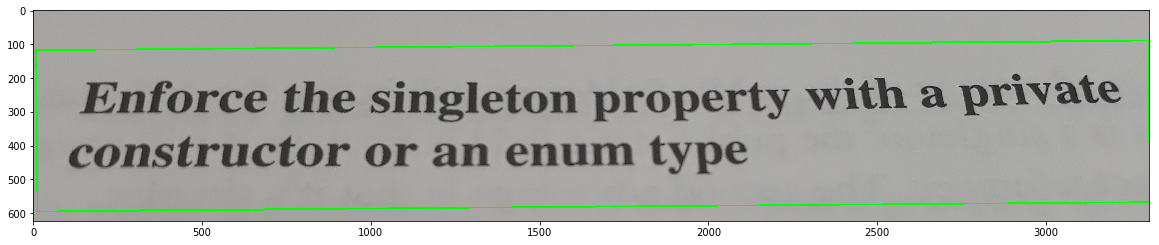

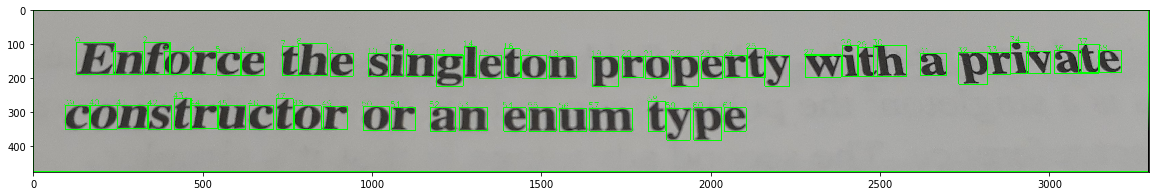

In [114]:
file_name = "test/test3.jpg"
text = do_magic(ann, file_name, remove_noise=True)
print(text)

##### 3. Translate

In [ ]:
print(translate(text))